In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import glob 
import random
from PIL import Image
from tqdm import tqdm

In [3]:
ngpu = 2                    # Number of GPUs available. Use 0 for CPU mode.
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# **Loading Data**

In [4]:
classes = { "cane": "dog",
            "cavallo": "horse",
            "elefante": "elephant",
            "farfalla": "butterfly",
            "gallina": "chicken", 
            "gatto": "cat",
            "mucca": "cow",
            "pecora": "sheep",
            "scoiattolo": "squirrel",
            "dog": "cane", 
            "cavallo": "horse",
            "elephant" : "elefante",
            "butterfly": "farfalla",
            "chicken": "gallina",
            "cat": "gatto", 
            "cow": "mucca",
            "spider": "ragno",
            "squirrel": "scoiattolo"}
data = {
    "path":[],
    "label":[]
}
data_dir="/kaggle/input/animals10/raw-img"

In [5]:
for label_it,label_en in classes.items():
    paths = glob.glob(f'{data_dir}/{label_it}/*.jpeg')

    data["path"].extend(paths)
    data["label"].extend([label_en] * len(paths))

df_data = pd.DataFrame(data)
df_data.head()

,path,label
0,/kaggle/input/animals10/raw-img/cane/OIP-6p-HH...,dog
1,/kaggle/input/animals10/raw-img/cane/OIP-A1GkR...,dog
2,/kaggle/input/animals10/raw-img/cane/OIP-GZmwq...,dog
3,/kaggle/input/animals10/raw-img/cane/OIP-Yj0uE...,dog
4,/kaggle/input/animals10/raw-img/cane/OIP-bbrbp...,dog


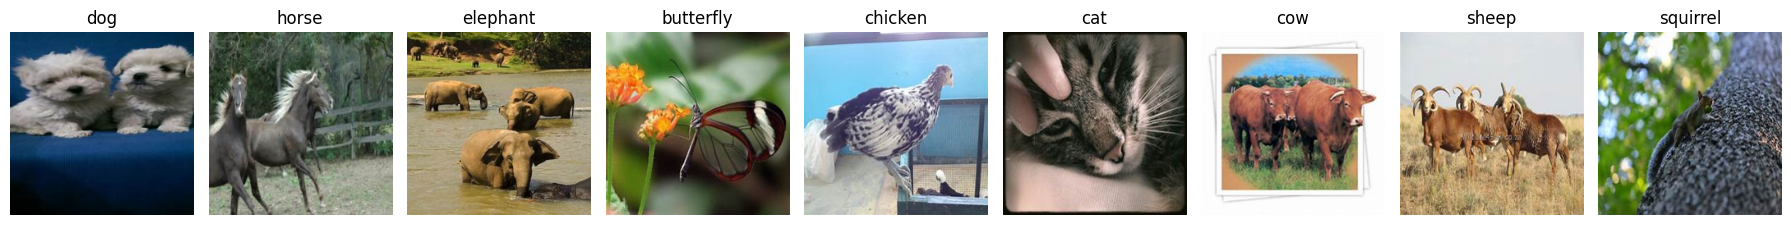

In [6]:
plt.figure(figsize = (20, 7))

for idx, i in enumerate(df_data.label.unique()):
    plt.subplot(1, 10, idx + 1)
    df = df_data[df_data['label'] == i].reset_index(drop=True)
    
    image_path = df.loc[random.randint(0, len(df) - 1), 'path']
    img = Image.open(image_path)
    img = img.resize((224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    
plt.tight_layout()
plt.show()

# **Dataset for Pytorch**

In [7]:
transform = transforms.Compose([
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
Dataset = datasets.ImageFolder(root=data_dir, transform=transform)
# Print the number of classes
num_classes = len(Dataset.classes)
print(f"Number of classes: {num_classes}")

# Print the number of samples
num_samples = len(Dataset)
print(f"Number of samples: {num_samples}")

Number of classes: 10
Number of samples: 26179


In [9]:
train_size = int(0.8 * len(Dataset))  # 80% for training
test_size = len(Dataset) - train_size  # 20% for testing
# split dataset
train_dataset, test_dataset = random_split(Dataset, [train_size, test_size])

# Create data loaders for the train and test datasets
batch_size = 32  # You can adjust this value as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **ResidualBlock for Resnet50**

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# **Model**

In [11]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# **Hyparameters**

In [12]:
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))
    
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

# **Training**

In [13]:
import gc
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

Epoch [1/20], Loss: 2.3572
Accuracy of the network on the 5000 validation images: 35.370511841100075 %
Epoch [2/20], Loss: 1.2558
Accuracy of the network on the 5000 validation images: 51.814362108479756 %
Epoch [3/20], Loss: 1.0308
Accuracy of the network on the 5000 validation images: 54.22077922077922 %
Epoch [4/20], Loss: 0.6626
Accuracy of the network on the 5000 validation images: 60.6951871657754 %
Epoch [5/20], Loss: 1.3492
Accuracy of the network on the 5000 validation images: 64.0183346065699 %
Epoch [6/20], Loss: 0.8946
Accuracy of the network on the 5000 validation images: 67.37967914438502 %
Epoch [7/20], Loss: 0.8852
Accuracy of the network on the 5000 validation images: 70.24446142093201 %
Epoch [8/20], Loss: 0.7348
Accuracy of the network on the 5000 validation images: 73.2620320855615 %
Epoch [9/20], Loss: 0.6674
Accuracy of the network on the 5000 validation images: 74.17876241405654 %
Epoch [10/20], Loss: 0.5918
Accuracy of the network on the 5000 validation images: 

## **Testing with test_loader**

In [14]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

Accuracy of the network on the 10000 test images: 75.17188693659281 %


In [15]:
# Choose a subset of the testing dataset
num_images_to_show = 50
subset_indices = range(num_images_to_show)

In [16]:
# Classes
newClass = ["dog", 
           "horse", 
           "elephant", 
           "butterfly", 
           "chicken", 
           "cat", 
           "cow", 
           "sheep", 
           "squirrel", 
           "cane", 
           "horse", 
           "elefante",
           "farfalla", 
           "gallina", 
           "gatto",
           "mucca",
           "ragno",
           "scoiattolo"]

23it [00:04,  5.10it/s]


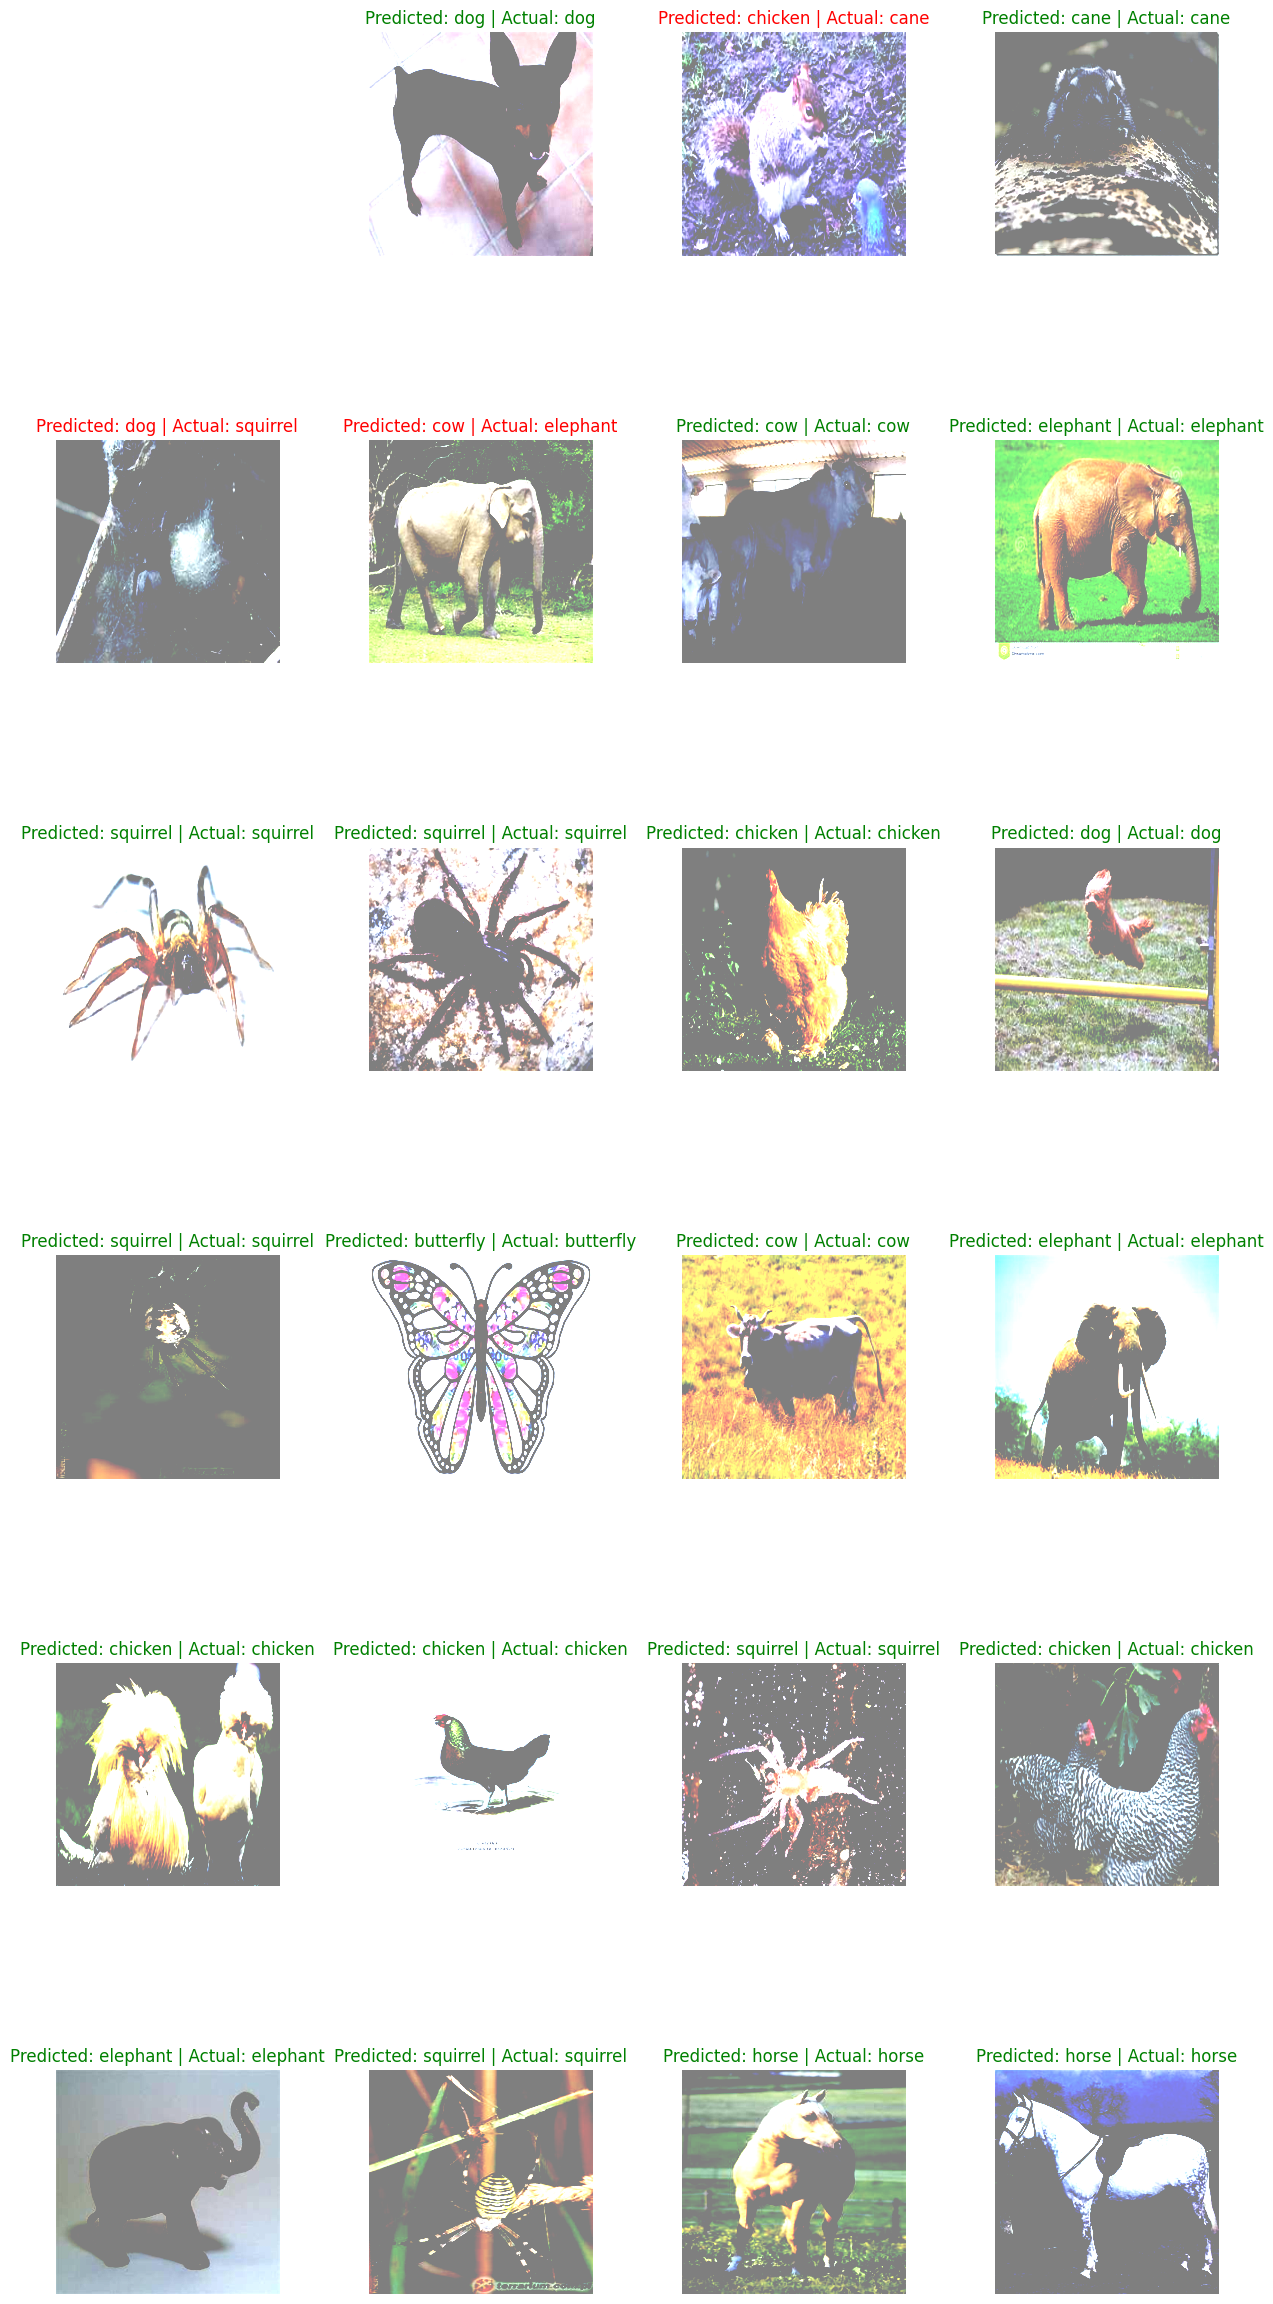

In [17]:
# Make predictions and plot images with predicted labels
plt.figure(figsize=(15, 30))
for i, (image, label) in tqdm(enumerate(test_loader, 1)):
    if i >= 24:
        break
        
    with torch.no_grad():
        images = image.to(device)
        labels = label.to(device)
        output =  model(images)
        _, predicted = torch.max(output.data, 1)
        
        plt.subplot(6, 4, i+1)
        
        # Ensure pixel values are in the [0, 1] range
        image = torch.clamp(image, 0, 1)
        plt.imshow((image[0] * 0.5 + 0.5).permute(1, 2, 0))
        if(newClass[predicted[0]]==newClass[label[0]]):
            plt.title(f'Predicted: {newClass[predicted[0]]} | Actual: {newClass[label[0]]}',color="green")
        else:
            plt.title(f'Predicted: {newClass[predicted[0]]} | Actual: {newClass[label[0]]}',color="red")
       
        plt.axis('off')
    
        if i >= num_images_to_show:
            break

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()